# A Deep Neural Network

I am using a ConvNet in tandem with a Gaussian Process to regress 32 electrode readings into the expected lung volume measurement. Inputs are 32x224 matrices, corresponding to 32 electrodes, with 224 patterns. 

I also include occlusions and elevations as targets. 

In [1]:
%matplotlib inline

#Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
!ls data9

EITimages.mat  loss_logs_single.csv  testImages		 trainOccl.csv
elec.csv       README(1).docx	     testImages.mat	 valid_results.csv
getEitImage.m  README.docx	     test_lessdense.csv  ypred_multi.csv
heartVols.mat  test.csv		     testOccl		 ypred_single.csv
iipats.csv     test_denser.csv	     train.csv		 ytest_multi.csv
loss_logs.csv  testElev.csv	     trainElev.csv	 ytest_single.csv


In [4]:
# Make Cyclic By Rolling Over 1st K rows to Edge
cyclic = lambda x, K=4: np.append(x,x[:,:,:K,:,:],axis=2)

In [60]:
# Load Others
def load_data(path,test=False):
    if not test:
        dfile = path + '/train.csv'
        data   = pd.read_csv(dfile,header=None).values
        x_data = data[:,:-1].reshape((11,-1,32,224,1)).transpose(1,0,2,3,4)
        x_data = cyclic(x_data)
        y_data = data[:, -1].reshape((11,-1)).transpose(1,0)
    
    else:
        tfile = path + '/test.csv'
        data   = pd.read_csv(tfile,header=None).values
        x_data = data[:,:-1].reshape((11,-1,32,224,1)).transpose(1,0,2,3,4)
        x_data = cyclic(x_data)
        y_data = data[:, -1].reshape((11,-1)).transpose(1,0)
        
    return x_data,y_data

In [6]:
# Load Data
path  = 'data9'
x_data,l_data=load_data(path)   # x: -1,11,32,224,1

In [7]:
print 'X shape:', x_data.shape
print 'L shape:', l_data.shape

X shape: (7000, 11, 36, 224, 1)
L shape: (7000, 11)


In [8]:
# Scale Data
ysclr  = RobustScaler().fit(l_data.reshape(-1,1))
y_data = ysclr.transform(l_data.reshape(-1,1)).reshape(-1,11)

In [9]:
# Reshaping Back
x_train,x_valid,y_train,y_valid = train_test_split(x_data,y_data,test_size=0.3,random_state=32)

nshp = (-1,) + x_data.shape[2:]
x_train = x_train.reshape(nshp)
y_train = y_train.reshape(-1)

x_valid = x_valid.reshape(nshp)
y_valid = y_valid.reshape(-1)

print 'X train:', x_train.shape
print 'Y train:', y_train.shape

X train: (53900, 36, 224, 1)
Y train: (53900,)


## Regressor Model

In [10]:
# Keras Imports
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, AveragePooling2D, UpSampling2D
from keras.layers import Flatten, Reshape,Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import PReLU
from keras import regularizers
from keras import backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard

/home/junior/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
## Training Params
num_batch = 32#256
num_epoch = 80#100
patience  = 10

# Parameters
# ndim = x_train.shape[1]
npat,ndim,_ = x_train.shape[1:]
L1   = 127
L2   = 169
L3   = 16

In [12]:
# Build DNN
def build_model():
    x = Input(shape=(npat,ndim,1),name='Input')
    h = Conv2D(28,activation='relu',kernel_size=(3,5),strides=(2,3),padding='same',name='L1')(x)
    h = BatchNormalization()(h)
    h = Conv2D(16,activation='relu',kernel_size=(3,3),strides=(2,3),padding='same',name='L2')(h)
    h = BatchNormalization()(h)
    h = Conv2D(15,activation='relu',kernel_size=(3,3),strides=(1,3),padding='same',name='L3')(h)
    h = BatchNormalization()(h)
    h = AveragePooling2D((2,2),strides=(2,2))(h)
    h = Flatten()(h)
    h = Dense(7,activation='tanh',name='L4')(h)
    y = Dense(1,activation='linear',name='Output')(h)
    model   = Model(x,y)
    encoder = Model(x,h) 
    return model, encoder

In [13]:
# Compile Model
model,encoder = build_model()
encoder.compile(optimizer='adam', loss='mean_squared_error')

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 36, 224, 1)        0         
_________________________________________________________________
L1 (Conv2D)                  (None, 18, 75, 28)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 75, 28)        112       
_________________________________________________________________
L2 (Conv2D)                  (None, 9, 25, 16)         4048      
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 25, 16)         64        
_________________________________________________________________
L3 (Conv2D)                  (None, 9, 9, 15)          2175      
_________________________________________________________________
batch_normalization_3 (Batch (None, 9, 9, 15)          60        
__________

In [14]:
# Train
log = model.fit(x_train, y_train,
                batch_size=num_batch,
                epochs=num_epoch,
                shuffle=True,
                validation_data=(x_valid,y_valid))

Train on 53900 samples, validate on 23100 samples
Epoch 1/80
53900/53900 [==============================] - 38s 697us/step - loss: 0.1654 - val_loss: 0.0472
Epoch 2/80
53900/53900 [==============================] - 14s 268us/step - loss: 0.0279 - val_loss: 0.0228
Epoch 3/80
53900/53900 [==============================] - 14s 264us/step - loss: 0.0148 - val_loss: 0.0168
Epoch 4/80
53900/53900 [==============================] - 15s 271us/step - loss: 0.0100 - val_loss: 0.0122
Epoch 5/80
53900/53900 [==============================] - 16s 289us/step - loss: 0.0075 - val_loss: 0.0086
Epoch 6/80
53900/53900 [==============================] - 15s 285us/step - loss: 0.0063 - val_loss: 0.0075
Epoch 7/80
53900/53900 [==============================] - 15s 287us/step - loss: 0.0054 - val_loss: 0.0080
Epoch 8/80
53900/53900 [==============================] - 16s 290us/step - loss: 0.0049 - val_loss: 0.0069
Epoch 9/80
53900/53900 [==============================] - 15s 285us/step - loss: 0.0044 - val_

In [35]:
# model.save('singletask_net.h5')

In [27]:
model = load_model('singletask_net.h5')

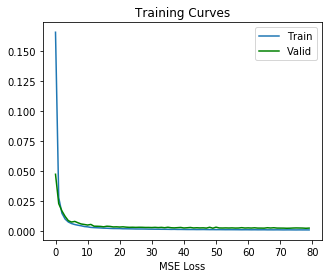

In [17]:
# Training Curves
plt.figure(figsize=(5,4))
plt.plot(log.epoch,log.history['loss'])
plt.plot(log.epoch,log.history['val_loss'],'g')
plt.title('Training Curves')
plt.xlabel('Epochs')
plt.xlabel('MSE Loss')
plt.legend(['Train','Valid'])

In [18]:
tloss = log.history['loss']
vloss = log.history['val_loss']
epchs = np.arange(len(tloss))

dl = pd.DataFrame({
    'Epoch': epchs,
    'Tloss': tloss,
    'Vloss': vloss
})

dl.to_csv(path+'/loss_logs_single.csv',index=False)

### Validation Curves

In [19]:
y_vpred = model.predict(x_valid).reshape(-1,11)
y_vtrue = y_valid.reshape(-1,11)

In [30]:
rmse = lambda x,y : np.sqrt(np.mean((x-y)**2))

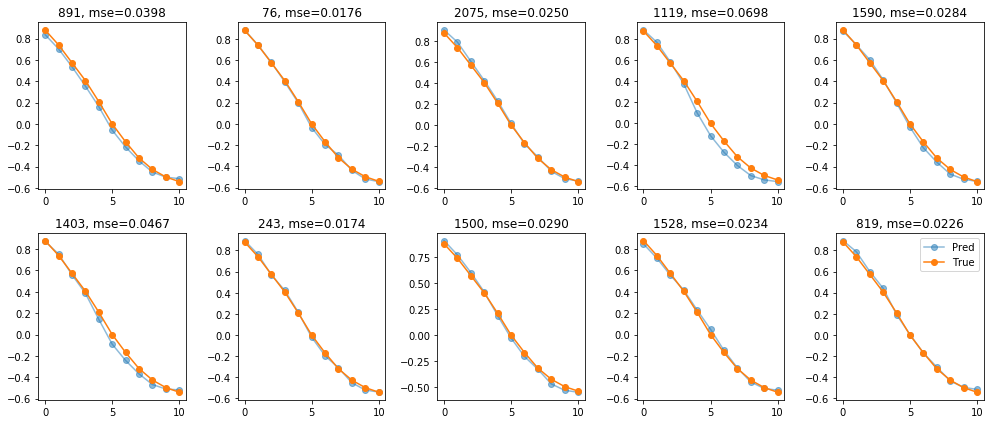

In [21]:
K = 10
row = 2
col = K/row

sidx = random.sample(range(len(y_vtrue)),K)

plt.figure(figsize=(14,6));
for i,k in enumerate(sidx):
    plt.subplot(row,col,i+1)
    plt.plot(y_vpred[k],'o-',label='Pred',alpha=0.5);
    plt.plot(y_vtrue[k],'o-',label='True');
    mse = rmse(y_vpred[k],y_vtrue[k])
    header = '{0}, mse={1:.04f}'.format(k,mse)
    plt.title(header);
    
plt.legend();
plt.tight_layout();

In [22]:
# # Save
# y_tst = ysclr.inverse_transform(y_vtrue.reshape(-1,1)).squeeze()
# y_prd = ysclr.inverse_transform(y_vpred.reshape(-1,1)).squeeze()

# vdata = np.stack([y_tst,y_prd],axis=1)
# oname = path +'/valid_results.csv'
# np.savetxt(oname,vdata,delimiter=',',header='True,Pred')

## Test Curves

In [61]:
# Generate Predictions for Test Set
x_test,y_test = load_data(path,test=True)
x_test = x_test.reshape(nshp)

In [62]:
y_pred = model.predict(x_test)
y_pred = ysclr.inverse_transform(y_pred).reshape(-1,11)

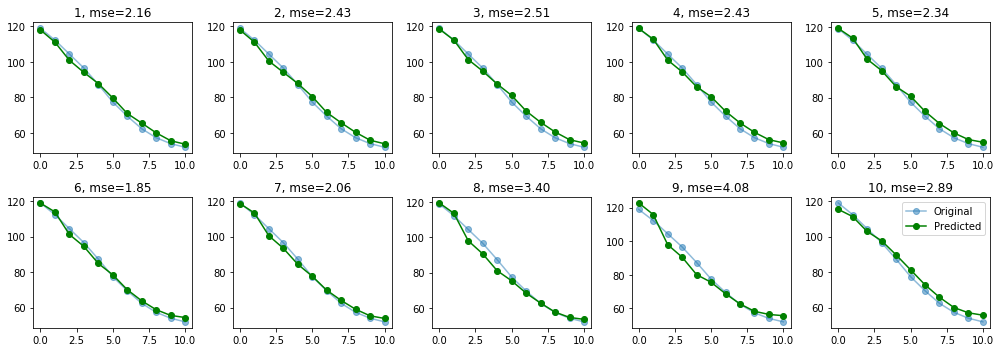

In [63]:
# Plot Test Examples
row = 2
col = 5

plt.figure(figsize=(14,5));
for i, (yt,yp) in enumerate(zip(y_test,y_pred)):
    plt.subplot(row,col,i+1)
    plt.plot(yt,'o-',label='True',alpha=0.5);
    plt.plot(yp,'go-',label='Pred');
    mse = rmse(yp,yt)
    header = '{0}, mse={1:.02f}'.format(i+1,mse)
    plt.title(header);

plt.legend(['Original','Predicted'],loc=1)
plt.tight_layout()

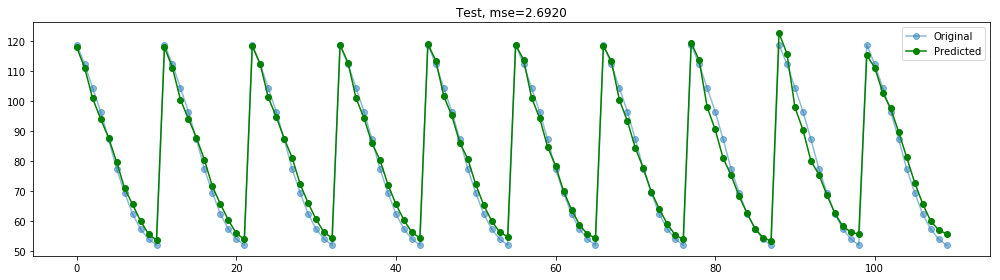

In [64]:
# Plot Results
plt.figure(figsize=(14,4))
plt.subplot(111)
plt.plot(y_test[:25,:].flatten(),'o-',alpha=0.5)
plt.plot(y_pred[:25,:].flatten(),'go-')
mse = rmse(y_pred,y_test)
header = 'Test, mse={0:.04f}'.format(mse)
plt.title(header)

plt.legend(['Original','Predicted'],loc=1)
plt.tight_layout()

In [54]:
# Save Values
oname = path + '/ypred.csv'
tname = path + '/ytest.csv'
np.savetxt(oname,y_pred,delimiter=',')
np.savetxt(tname,y_test,delimiter=',')

----